<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/enhancing_chat_bot_with_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick **Start**
In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

Answer common questions by searching the web Maintain conversation state across calls Route complex queries to a human for review Use custom state to control its behavior Rewind and explore alternative conversation paths We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

Setup First, install the required packages:

In [32]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community


In [33]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('my_stenographer_key')
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [34]:

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults # Import the necessary class
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("what is current weather in karachi")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1730969741, 'localtime': '2024-11-07 13:55'}, 'current': {'last_updated_epoch': 1730969100, 'last_updated': '2024-11-07 13:45', 'temp_c': 30.8, 'temp_f': 87.5, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 14.8, 'wind_kph': 23.8, 'wind_degree': 251, 'wind_dir': 'WSW', 'pressure_mb': 1013.0, 'pressure_in': 29.9, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 61, 'cloud': 0, 'feelslike_c': 35.0, 'feelslike_f': 95.0, 'windchill_c': 30.8, 'windchill_f': 87.5, 'heatindex_c': 35.0, 'heatindex_f': 95.0, 'dewpoint_c': 22.5, 'dewpoint_f': 72.5, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 6.4, 'gust_mph': 17.0, 'gust_kph': 27.3}}"},
 {'url': 'https://www.ventusky.com/karachi',
  'content': "کراچی (Karachi) Pakistan / 

In [41]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END  # Ensure END is imported
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, ToolMessage
from IPython.display import Image, display
from typing import Literal


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [42]:
tools_by_name = {tool.name: tool for tool in tools}
print(type(tools_by_name))
print(tools_by_name)

tools_by_name["tavily_search_results_json"]

llm_with_tools.invoke("search using tool and what polls say about winner 2024 presidential elections")

<class 'dict'>
{'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}


AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "polls about 2024 presidential elections"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-33a19bfc-8a53-4a6c-b3dc-db4887a6898b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'polls about 2024 presidential elections'}, 'id': '5c27bdb8-fcd2-4dfa-a1bc-057958d31d6b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 90, 'output_tokens': 28, 'total_tokens': 118, 'input_token_details': {'

In [43]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [44]:
from langchain_core.messages import HumanMessage, AIMessage

messages = [
AIMessage(content='',
          additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "2024 presidential elections polls"}'}},
          response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []},
          id='run-621e608b-24ae-4d50-8605-33415037f7df-0',
          tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024 presidential elections polls'}, 'id': '826c7148-a96a-4f79-9c64-325c97489d5e', 'type': 'tool_call'}],
          usage_metadata={'input_tokens': 90, 'output_tokens': 16, 'total_tokens': 106, 'input_token_details': {'cache_read': 0}})
]

tool_node(inputs={"messages": messages})

{'messages': [ToolMessage(content='[{"url": "https://www.270towin.com/2024-presidential-election-polls/", "content": "This page displays the current 270toWin Polling Average for each state. Where that is not applicable, the most recent 2024 presidential election poll is used. The average methodology is summarized below the table. The default view is Harris vs. Trump head-to-head. To view averages including 3rd party candidates, select the checkbox near the"}, {"url": "https://projects.fivethirtyeight.com/polls/president-general/2024/", "content": "Sort by date\\nSAMPLE TYPES\\nA\\nADULTS\\nV\\nVOTERS\\nLV\\nLIKELY VOTERS\\nRV\\nREGISTERED VOTERS\\nSAMPLE TYPES\\nA\\nADULTS\\nV\\nVOTERS\\nLV\\nLIKELY VOTERS\\nRV\\nREGISTERED VOTERS\\nPolls\\nending\\nDec. 5, 2023\\nPresident: general election, 2024\\nBiden\\nHaley\\nBiden\\nTrump\\nKennedy\\nStein\\nWest\\nBiden\\nTrump\\nDec. 4, 2023\\nPresident: general election, 2024\\nBiden\\nTrump\\nDec. 3, 2023\\nPresident: general election, 2024\

In [45]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

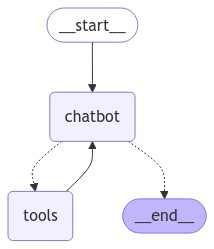

In [46]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input):
    """Handles user input and updates the graph visualization."""
    # Placeholder for the actual logic to update the graph visualization
    print(f"Processing user input: {user_input}")
    # Example:  You might replace this with code to update the graph with new nodes or edges based on user input
    # For example, you could use graph.add_node() or graph.add_edge() to modify the graph
    # display(Image(graph.get_graph().draw_mermaid_png()))

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input) # Call the defined function
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input) # Call the defined function
        break

User: what is current date in karachi?
Processing user input: what is current date in karachi?


In [59]:
tool.invoke("what is current weather in karachi?")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1730970613, 'localtime': '2024-11-07 14:10'}, 'current': {'last_updated_epoch': 1730970000, 'last_updated': '2024-11-07 14:00', 'temp_c': 30.8, 'temp_f': 87.4, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 15.2, 'wind_kph': 24.5, 'wind_degree': 253, 'wind_dir': 'WSW', 'pressure_mb': 1012.0, 'pressure_in': 29.89, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 62, 'cloud': 0, 'feelslike_c': 35.0, 'feelslike_f': 95.0, 'windchill_c': 30.8, 'windchill_f': 87.4, 'heatindex_c': 35.0, 'heatindex_f': 95.0, 'dewpoint_c': 22.6, 'dewpoint_f': 72.8, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 5.2, 'gust_mph': 17.5, 'gust_kph': 28.2}}"},
 {'url': 'https://www.timeanddate.com/weather/pakistan/karachi',
  'content': 'Karach